In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
#from tqdm import tqdm

# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import  confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import pandas as pd

%matplotlib inline

In [2]:
features_og = pd.read_pickle('./Features Data/trainingFeatures.pickle')

#### Spectral clustering

In [3]:
# drop features
features = pd.DataFrame(features_og['mfcc'])
features -= features.mean(axis=0)
features /= features.std(axis=0)

distances = spatial.distance.squareform(spatial.distance.pdist(features,'cosine'))

n=distances.shape[0]
kernel_width = distances.mean()
weights = np.exp(np.divide(-np.square(distances),kernel_width**2))
np.fill_diagonal(weights,0)

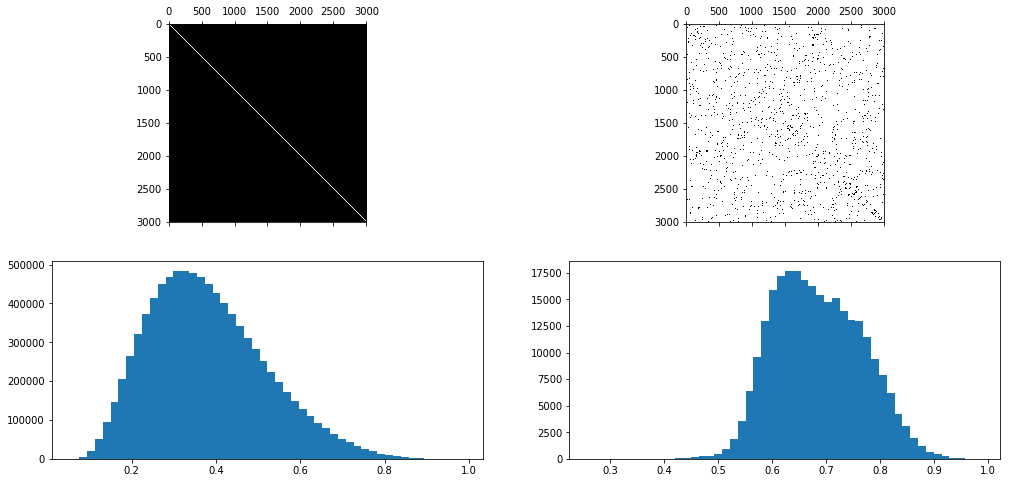

In [4]:
fix, axes = plt.subplots(2, 2, figsize=(17, 8))
def plot(weights, axes):
    axes[0].spy(weights)
    axes[1].hist(weights[weights > 0].reshape(-1), bins=50);
plot(weights, axes[:, 0])

NEIGHBORS = 120

for i in range(weights.shape[0]):
    idx = weights[i,:].argsort()[:-NEIGHBORS]
    weights[i,idx] = 0
    weights[idx,i] = 0

plot(weights, axes[:, 1])
   

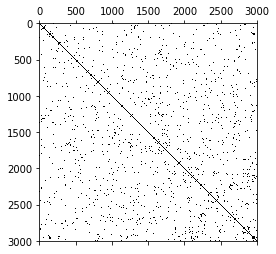

In [5]:
degrees = np.sum(weights,axis=0)
laplacian = np.diag(degrees**-0.5) @ (np.diag(degrees) - weights) @ np.diag(degrees**-0.5)
laplacian = sparse.csr_matrix(laplacian)
plt.spy(laplacian.todense());

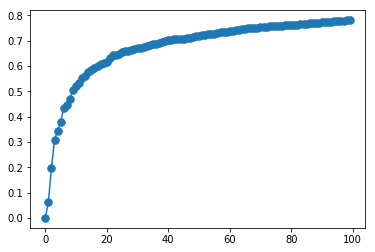

In [6]:
eigenvalues, eigenvectors = sparse.linalg.eigsh(A=laplacian,k=100,which='SM')
plt.plot(eigenvalues, '.-', markersize=15);


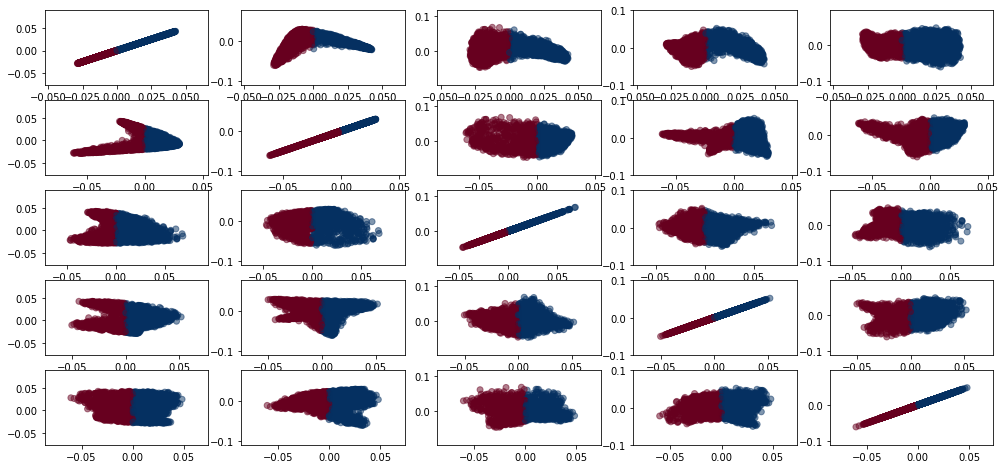

In [7]:
fix, axes = plt.subplots(5, 5, figsize=(17, 8))
for i in range(1,6):
    for j in range(1,6):
        x = eigenvectors[:,i]
        y = eigenvectors[:,j]
        labels = np.sign(x)
        axes[i-1,j-1].scatter(x, y, c=labels, cmap='RdBu', alpha=0.5)

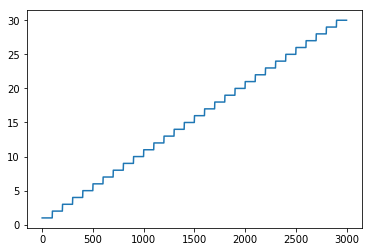

In [8]:
#features_og['mfcc']

# Stolen code from Manuel

# Build Label vector
# Define class name vector, the index will correspond to the class label
class_names = features_og['info']['word'].unique()
label_vec = np.ones(len(features_og))
for i in range(0,len(class_names)):
    label_vec +=(features_og['info','word'] == class_names[i]) * i
    
#equalize label count
#label_vec = label_vec[1800:]    

label_vec.plot()

In [9]:
# sample classes such as test and train have equal proportion of classes

train_size = 80
test_size = 20

train_x = np.array([])
train_y = np.array([])

test_x = np.array([])
test_y = np.array([])

for i in range(len(class_names)):
    class_index = np.where(label_vec == (i+1))[0]
    random_index = np.random.choice(range(len(class_index)), size=train_size+test_size, replace=False)
    
    train_x_class = class_index[random_index[:train_size]]
    train_y_class = label_vec[train_x_class]
    train_x = np.append(train_x, train_x_class)
    train_y = np.append(train_y, train_y_class)

    test_x_class = class_index[random_index[train_size:train_size+test_size]]
    test_y_class = label_vec[test_x_class]
    test_x = np.append(test_x, test_x_class)
    test_y = np.append(test_y, test_y_class)
    

In [10]:
# get features
train_features = eigenvectors[train_x.astype(int),:]
test_features = eigenvectors[test_x.astype(int),:]


Build support vector machine classifier :

In [11]:
clf = SVC(C=1.0, 
          kernel='rbf', 
          gamma='auto', 
          tol=1e-6, 
          class_weight=None, 
          verbose=True, 
          max_iter=-1, 
          decision_function_shape='ovr')

In [12]:
clf.fit(train_features, train_y)  

[LibSVM]

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=1e-06, verbose=True)

In [13]:
predict_y = clf.predict(test_features)
print('accuracy : ', np.sum(test_y==predict_y)/len(test_y))

accuracy :  0.255


Build neural network :

In [14]:
clf = MLPClassifier(hidden_layer_sizes=(32, ), 
                    activation='relu', 
                    solver='adam', 
                    alpha=0.0001, 
                    learning_rate='adaptive',
                    learning_rate_init=0.001, 
                    power_t=0.5, 
                    max_iter=10000,
                    tol=1e-6, 
                    verbose=True)


In [15]:
clf.fit(train_features, train_y)  

Iteration 1, loss = 3.41991732
Iteration 2, loss = 3.41563640
Iteration 3, loss = 3.41177002
Iteration 4, loss = 3.40835767
Iteration 5, loss = 3.40511055
Iteration 6, loss = 3.40192138
Iteration 7, loss = 3.39902434
Iteration 8, loss = 3.39612205
Iteration 9, loss = 3.39320540
Iteration 10, loss = 3.39040001
Iteration 11, loss = 3.38765285
Iteration 12, loss = 3.38491895
Iteration 13, loss = 3.38201399
Iteration 14, loss = 3.37904995
Iteration 15, loss = 3.37616229
Iteration 16, loss = 3.37308191
Iteration 17, loss = 3.36988293
Iteration 18, loss = 3.36669178
Iteration 19, loss = 3.36322429
Iteration 20, loss = 3.35975873
Iteration 21, loss = 3.35613060
Iteration 22, loss = 3.35238107
Iteration 23, loss = 3.34836515
Iteration 24, loss = 3.34433119
Iteration 25, loss = 3.34004646
Iteration 26, loss = 3.33557801
Iteration 27, loss = 3.33100175
Iteration 28, loss = 3.32627184
Iteration 29, loss = 3.32130924
Iteration 30, loss = 3.31610205
Iteration 31, loss = 3.31069236
Iteration 32, los

Iteration 256, loss = 1.93909988
Iteration 257, loss = 1.93713497
Iteration 258, loss = 1.93510861
Iteration 259, loss = 1.93320084
Iteration 260, loss = 1.93156947
Iteration 261, loss = 1.92989917
Iteration 262, loss = 1.92789612
Iteration 263, loss = 1.92607444
Iteration 264, loss = 1.92444410
Iteration 265, loss = 1.92274620
Iteration 266, loss = 1.92100659
Iteration 267, loss = 1.91948440
Iteration 268, loss = 1.91748696
Iteration 269, loss = 1.91597336
Iteration 270, loss = 1.91398939
Iteration 271, loss = 1.91251661
Iteration 272, loss = 1.91073092
Iteration 273, loss = 1.90916360
Iteration 274, loss = 1.90767187
Iteration 275, loss = 1.90586166
Iteration 276, loss = 1.90441625
Iteration 277, loss = 1.90247639
Iteration 278, loss = 1.90094996
Iteration 279, loss = 1.89965818
Iteration 280, loss = 1.89805206
Iteration 281, loss = 1.89642550
Iteration 282, loss = 1.89501338
Iteration 283, loss = 1.89347135
Iteration 284, loss = 1.89204465
Iteration 285, loss = 1.89016240
Iteration 

Iteration 510, loss = 1.68040960
Iteration 511, loss = 1.67952992
Iteration 512, loss = 1.67889519
Iteration 513, loss = 1.67838967
Iteration 514, loss = 1.67796405
Iteration 515, loss = 1.67688172
Iteration 516, loss = 1.67653055
Iteration 517, loss = 1.67580142
Iteration 518, loss = 1.67525484
Iteration 519, loss = 1.67484357
Iteration 520, loss = 1.67408521
Iteration 521, loss = 1.67353713
Iteration 522, loss = 1.67268806
Iteration 523, loss = 1.67208004
Iteration 524, loss = 1.67169556
Iteration 525, loss = 1.67113703
Iteration 526, loss = 1.67034686
Iteration 527, loss = 1.66984377
Iteration 528, loss = 1.66925754
Iteration 529, loss = 1.66871418
Iteration 530, loss = 1.66787055
Iteration 531, loss = 1.66740196
Iteration 532, loss = 1.66697837
Iteration 533, loss = 1.66615793
Iteration 534, loss = 1.66592215
Iteration 535, loss = 1.66504889
Iteration 536, loss = 1.66472762
Iteration 537, loss = 1.66382203
Iteration 538, loss = 1.66341957
Iteration 539, loss = 1.66285042
Iteration 

Iteration 767, loss = 1.56232170
Iteration 768, loss = 1.56216860
Iteration 769, loss = 1.56187178
Iteration 770, loss = 1.56156281
Iteration 771, loss = 1.56133415
Iteration 772, loss = 1.56080854
Iteration 773, loss = 1.56064918
Iteration 774, loss = 1.56038861
Iteration 775, loss = 1.56006489
Iteration 776, loss = 1.55960087
Iteration 777, loss = 1.55920333
Iteration 778, loss = 1.55876192
Iteration 779, loss = 1.55845712
Iteration 780, loss = 1.55807290
Iteration 781, loss = 1.55790368
Iteration 782, loss = 1.55767256
Iteration 783, loss = 1.55725030
Iteration 784, loss = 1.55709846
Iteration 785, loss = 1.55668646
Iteration 786, loss = 1.55646279
Iteration 787, loss = 1.55599470
Iteration 788, loss = 1.55566071
Iteration 789, loss = 1.55548129
Iteration 790, loss = 1.55526394
Iteration 791, loss = 1.55475988
Iteration 792, loss = 1.55437638
Iteration 793, loss = 1.55408223
Iteration 794, loss = 1.55368407
Iteration 795, loss = 1.55363284
Iteration 796, loss = 1.55341860
Iteration 

Iteration 1027, loss = 1.49561733
Iteration 1028, loss = 1.49526923
Iteration 1029, loss = 1.49531424
Iteration 1030, loss = 1.49501063
Iteration 1031, loss = 1.49487478
Iteration 1032, loss = 1.49488232
Iteration 1033, loss = 1.49472541
Iteration 1034, loss = 1.49424095
Iteration 1035, loss = 1.49442965
Iteration 1036, loss = 1.49423047
Iteration 1037, loss = 1.49397344
Iteration 1038, loss = 1.49375729
Iteration 1039, loss = 1.49376480
Iteration 1040, loss = 1.49331701
Iteration 1041, loss = 1.49321306
Iteration 1042, loss = 1.49288144
Iteration 1043, loss = 1.49265922
Iteration 1044, loss = 1.49245350
Iteration 1045, loss = 1.49252115
Iteration 1046, loss = 1.49239350
Iteration 1047, loss = 1.49211831
Iteration 1048, loss = 1.49158808
Iteration 1049, loss = 1.49165523
Iteration 1050, loss = 1.49124652
Iteration 1051, loss = 1.49120812
Iteration 1052, loss = 1.49117384
Iteration 1053, loss = 1.49089346
Iteration 1054, loss = 1.49094948
Iteration 1055, loss = 1.49053137
Iteration 1056

Iteration 1268, loss = 1.45759081
Iteration 1269, loss = 1.45753541
Iteration 1270, loss = 1.45743627
Iteration 1271, loss = 1.45736574
Iteration 1272, loss = 1.45713273
Iteration 1273, loss = 1.45710368
Iteration 1274, loss = 1.45688929
Iteration 1275, loss = 1.45692278
Iteration 1276, loss = 1.45664924
Iteration 1277, loss = 1.45652156
Iteration 1278, loss = 1.45644220
Iteration 1279, loss = 1.45628895
Iteration 1280, loss = 1.45645122
Iteration 1281, loss = 1.45615630
Iteration 1282, loss = 1.45609842
Iteration 1283, loss = 1.45557495
Iteration 1284, loss = 1.45555661
Iteration 1285, loss = 1.45546374
Iteration 1286, loss = 1.45545067
Iteration 1287, loss = 1.45519018
Iteration 1288, loss = 1.45509528
Iteration 1289, loss = 1.45494194
Iteration 1290, loss = 1.45479524
Iteration 1291, loss = 1.45498722
Iteration 1292, loss = 1.45466340
Iteration 1293, loss = 1.45431267
Iteration 1294, loss = 1.45443572
Iteration 1295, loss = 1.45429354
Iteration 1296, loss = 1.45405794
Iteration 1297

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(32,), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=1e-06, validation_fraction=0.1,
       verbose=True, warm_start=False)

In [16]:
predict_y = clf.predict(test_features)
print('accuracy : ', np.sum(test_y==predict_y)/len(test_y))

accuracy :  0.321666666667


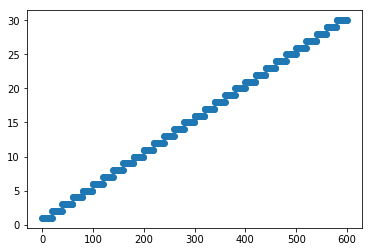

In [17]:
pd.Series(test_y).plot(linestyle='none',marker='o')

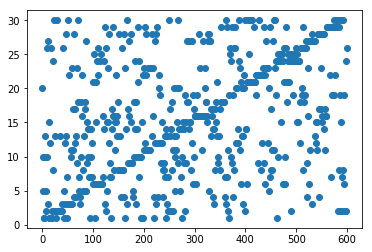

In [18]:
pd.Series(predict_y).plot(linestyle='none',marker='o')

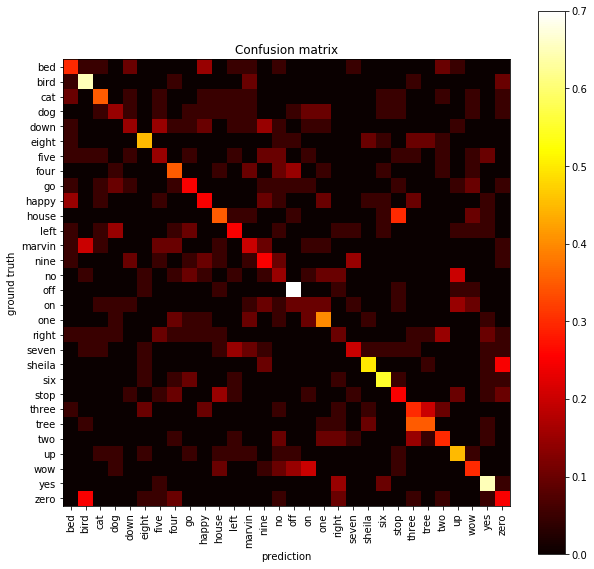

In [19]:
# confusion matrix from ADA
conf_mat=confusion_matrix(test_y,predict_y)

plt.figure(figsize=(10,10))
plt.imshow(conf_mat/np.sum(conf_mat,axis=1),cmap=plt.cm.hot)
tick = np.arange(len(class_names))
plt.xticks(tick, class_names,rotation=90)
plt.yticks(tick, class_names)
plt.ylabel('ground truth')
plt.xlabel('prediction')
plt.title('Confusion matrix')
plt.colorbar()